In [1]:
import pandas as pd
import numpy as np
from ggplot import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#read in header
with open("expedia_columnnames.csv") as f:
    colnames = f.readline().strip().split(",")

#read in data (1/1000 of original dataset)
expedia = pd.read_csv("expedia_2_1000.csv", header=None, names=colnames)

In [3]:
#reminder of header
expedia.columns.values

array(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt',
       'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id',
       'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent',
       'hotel_country', 'hotel_market', 'hotel_cluster'], dtype=object)

In [4]:
#ratio of mobile users
print expedia["is_mobile"].mean()

#ratio of successful orders
print expedia["is_booking"].mean()

#ratio of packaged orders
print expedia["is_package"].mean()

0.135541928805
0.0801677683098
0.252767380744


In [5]:
#create an empty dataframe
training = pd.DataFrame()
#create 3 columns of the year, month and day as of searching
training["search_year"] = expedia["date_time"].map(lambda s: s.split()[0].split("-")[0])
training["search_month"] = expedia["date_time"].map(lambda s: s.split()[0].split("-")[1])
training["search_day"] = expedia["date_time"].map(lambda s: s.split()[0].split("-")[2])
#create 3 columns of the year, month and day of C/I
training["ci_year"] = expedia[-expedia["srch_ci"].isnull()]["srch_ci"].map(lambda s: str(s).split("-")[0])
training["ci_month"] = expedia[-expedia["srch_ci"].isnull()]["srch_ci"].map(lambda s: str(s).split("-")[1])
training["ci_day"] = expedia[-expedia["srch_ci"].isnull()]["srch_ci"].map(lambda s: str(s).split("-")[2])
#add site name, as string, to the new dataframe
training["site"] = expedia["site_name"].map(str)
#add site continent to the new dataframe
training["site_continent"] = expedia["posa_continent"].map(str)
#add user country
training["user_country"] = expedia["user_location_country"].map(str)
#add destination distance
training["dest_dist"] = expedia["orig_destination_distance"]
#add is_mobile flag
training["mobile"] = expedia["is_mobile"]
#add is_package flag
training["package"] = expedia["is_package"]
#add number of hotel rooms
training["rooms"] = expedia["srch_rm_cnt"]
#add hotel country
training["hotel_country"] = expedia["hotel_country"].map(str)
#add hotel continent
training["hotel_continent"] = expedia["hotel_continent"].map(str)
#add is_booking flag
training["booking"] = expedia["is_booking"]
#add session history
training["history"] = expedia["cnt"]

In [6]:
#print first rows to verify the structure
training[:5]

,search_year,search_month,search_day,ci_year,ci_month,ci_day,site,site_continent,user_country,dest_dist,mobile,package,rooms,hotel_country,hotel_continent,booking,history
0,2014,08,11,2014,08,27,2,3,66,2234.2641,0,1,1,50,2,0,3
1,2014,08,13,2014,08,17,11,3,205,2221.7824,0,0,2,96,4,0,2
2,2014,12,27,2015,06,29,2,3,66,1002.2597,0,1,1,50,2,0,1
3,2014,09,22,2014,10,05,2,3,66,1355.7408,0,1,1,8,4,0,1
4,2014,03,30,2014,05,20,2,3,66,1062.0509,0,1,1,50,2,0,9


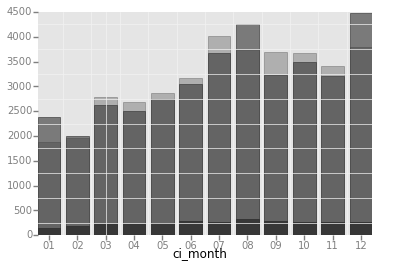

<ggplot: (8771700194113)>

In [7]:
#monthly viewing, booking and C/I pattern
ggplot(aes(x="search_month"), data=training) +\
    geom_bar(alpha=0.3) +\
    geom_bar(aes(x="search_month"), data=training[training["booking"]==1], alpha=0.9) +\
    geom_bar(aes(x="ci_month"), data=training, alpha=0.6)

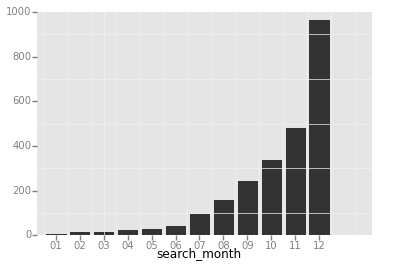

<ggplot: (8771698666325)>

In [8]:
#when do people look for hotels for Christmas season.
mask_christmas = training["ci_day"] > "20"
ggplot(aes(x="search_month"), data=training[training["ci_month"]=="12"][mask_christmas]) +\
    geom_bar() +\
    scale_fill_yhat()

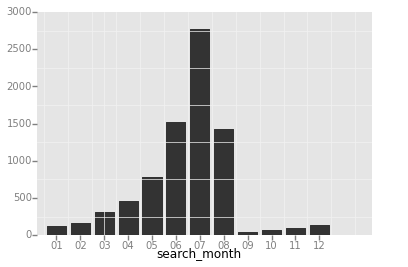

<ggplot: (8771698511845)>

In [9]:
#when do people look for hotels for summer vacation
mask_summer = training["ci_month"].map(lambda s: s in ["07", "08"])
ggplot(aes(x="search_month"), data=training[mask_summer]) + geom_bar()

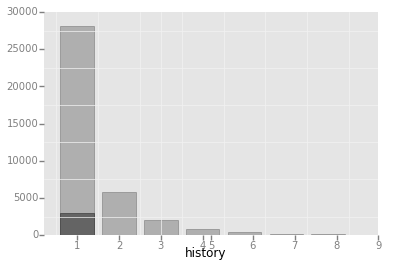

<ggplot: (8771698402541)>

In [10]:
#the distribution of how many searches the customer has made
ggplot(aes(x="history"), data=training) + geom_bar(alpha=0.3) + scale_x_continuous(limits=(0,8)) +\
    geom_bar(aes(x="history"), data=training[training["booking"]==1], alpha=0.6)

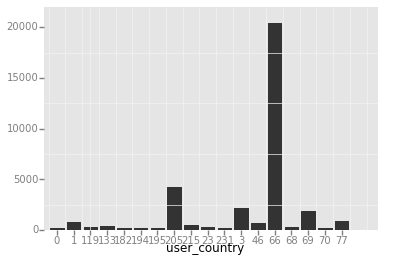

<ggplot: (8771698258625)>

In [11]:
#the distribution of user countries, match country number with name from annual reports
top90_cut = training["user_country"].value_counts().quantile(0.9)
top90 = training["user_country"].value_counts()
mask_top90 = training["user_country"].map(lambda s: top90[s] >= top90_cut)
ggplot(aes(x="user_country"), data=training[mask_top90]) + geom_bar() + scale_y_continuous(limits=(0,22000))

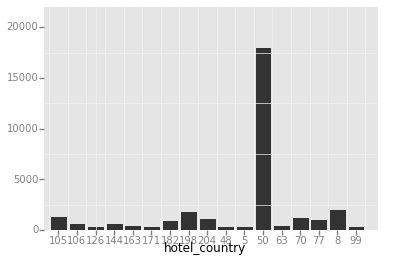

<ggplot: (8771698116789)>

In [12]:
#the distribution of hotel countries, match country number with name from annual reports
top90_cut = training["hotel_country"].value_counts().quantile(0.9)
top90 = training["hotel_country"].value_counts()
mask_top90 = training["hotel_country"].map(lambda s: top90[s] >= top90_cut)
ggplot(aes(x="hotel_country"), data=training[mask_top90]) + geom_bar() + scale_y_continuous(limits=(0,22000))

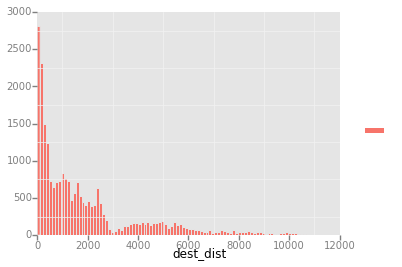

<ggplot: (8771698228485)>

In [13]:
#how far is the search
ggplot(aes(x="dest_dist", fill=""), data=training) + geom_histogram(bins=100)

In [14]:
#create a new column of days between searching and C/I
import datetime
mask_date_1 = -training["search_year"].isnull()
mask_date_2 = -training["ci_year"].isnull()
training_date = training[mask_date_1][mask_date_2][["search_year", "search_month", "search_day", "ci_year", "ci_month", "ci_day"]]
training_date["search_date"] = training_date[["search_year", "search_month", "search_day"]]\
    .apply(lambda s: datetime.datetime(year=int(s[0]), month=int(s[1]), day=int(s[2])), axis=1)
training_date["ci_date"] = training_date[["ci_year", "ci_month", "ci_day"]]\
    .apply(lambda s: datetime.datetime(year=int(s[0]), month=int(s[1]), day=int(s[2])), axis=1)

In [15]:
#only select the date columns in the dataframe, and calculate the advance period between searching and C/I
training_date = training_date[["search_date", "ci_date"]]
training_date["advance"] = (training_date["ci_date"] - training_date["search_date"]).map(lambda t: t.days)

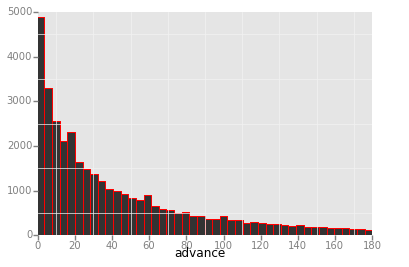

In [21]:
#print out the distribution of days of searching before C/I, aka "advance"
p = ggplot(aes(x="advance"), data=training_date) + geom_histogram(aes(color="red"), stat="bin", bins=500) + scale_x_continuous(limits=(0, 180))
# ggplot.save(p, "advance_hist")

In [ ]:
training_date["booking"] = training["booking"].copy()
#days of booking before C/I
ggplot(aes(x="advance", color="red"), data=training_date[training_date["booking"]==1]) + geom_bar()